In [1]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
import matplotlib as plt
import warnings
warnings.filterwarnings("ignore")

# Load the cleaned data
cleaned_data_path = 'Ready_For_MODEL_defense_spending.csv'  # Update the file path
df = pd.read_csv(cleaned_data_path)
df

,country,year,mil_usd,log_mil_usd,mil_usd_diff,mil_usd_diff2,mil_usd_growth,log_mil_usd_growth
0,China,1996,1.427540e+10,23.381804,1.890271e+09,-6.277381e+08,15.262427,14.204132
1,China,1997,1.569959e+10,23.476900,1.424186e+09,-4.660854e+08,9.976504,9.509656
2,China,1998,1.703178e+10,23.558347,1.332193e+09,-9.199252e+07,8.485532,8.144663
3,China,1999,2.047392e+10,23.742417,3.442135e+09,2.109941e+09,20.210071,18.407062
4,China,2000,2.223714e+10,23.825030,1.763225e+09,-1.678910e+09,8.612056,8.261223
...,...,...,...,...,...,...,...,...
79,United States,2019,7.343441e+11,27.322244,5.185270e+10,1.611423e+10,7.597561,7.322779
80,United States,2020,7.783972e+11,27.380503,4.405310e+10,-7.799600e+09,5.998972,5.825921
81,United States,2021,8.062302e+11,27.415635,2.783300e+10,-1.622010e+10,3.575681,3.513238
82,United States,2022,8.606922e+11,27.481003,5.446200e+10,2.662900e+10,6.755143,6.536764


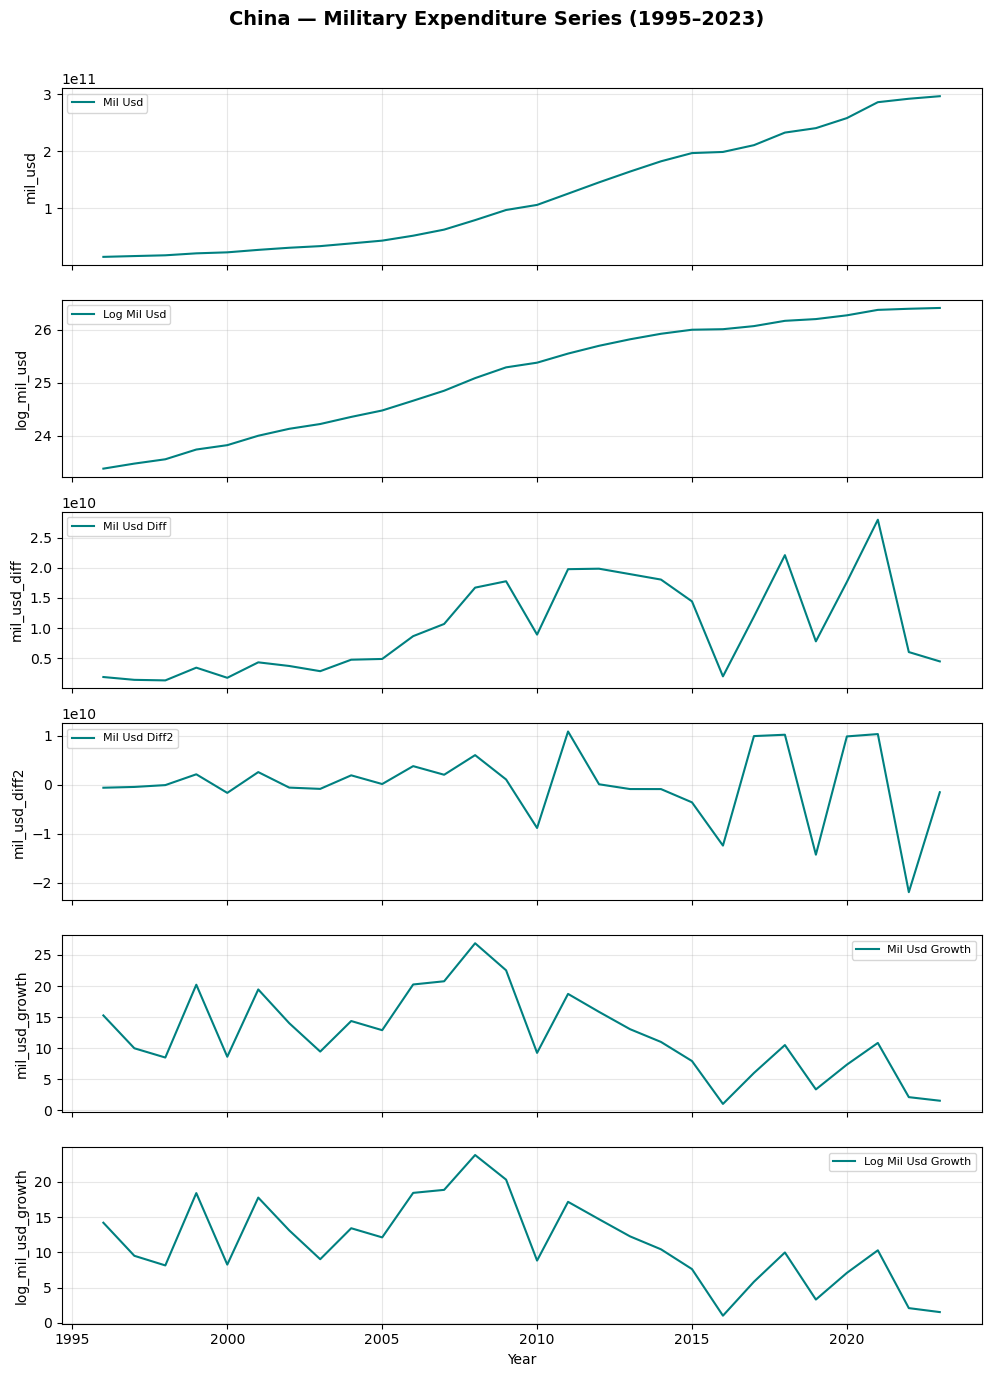

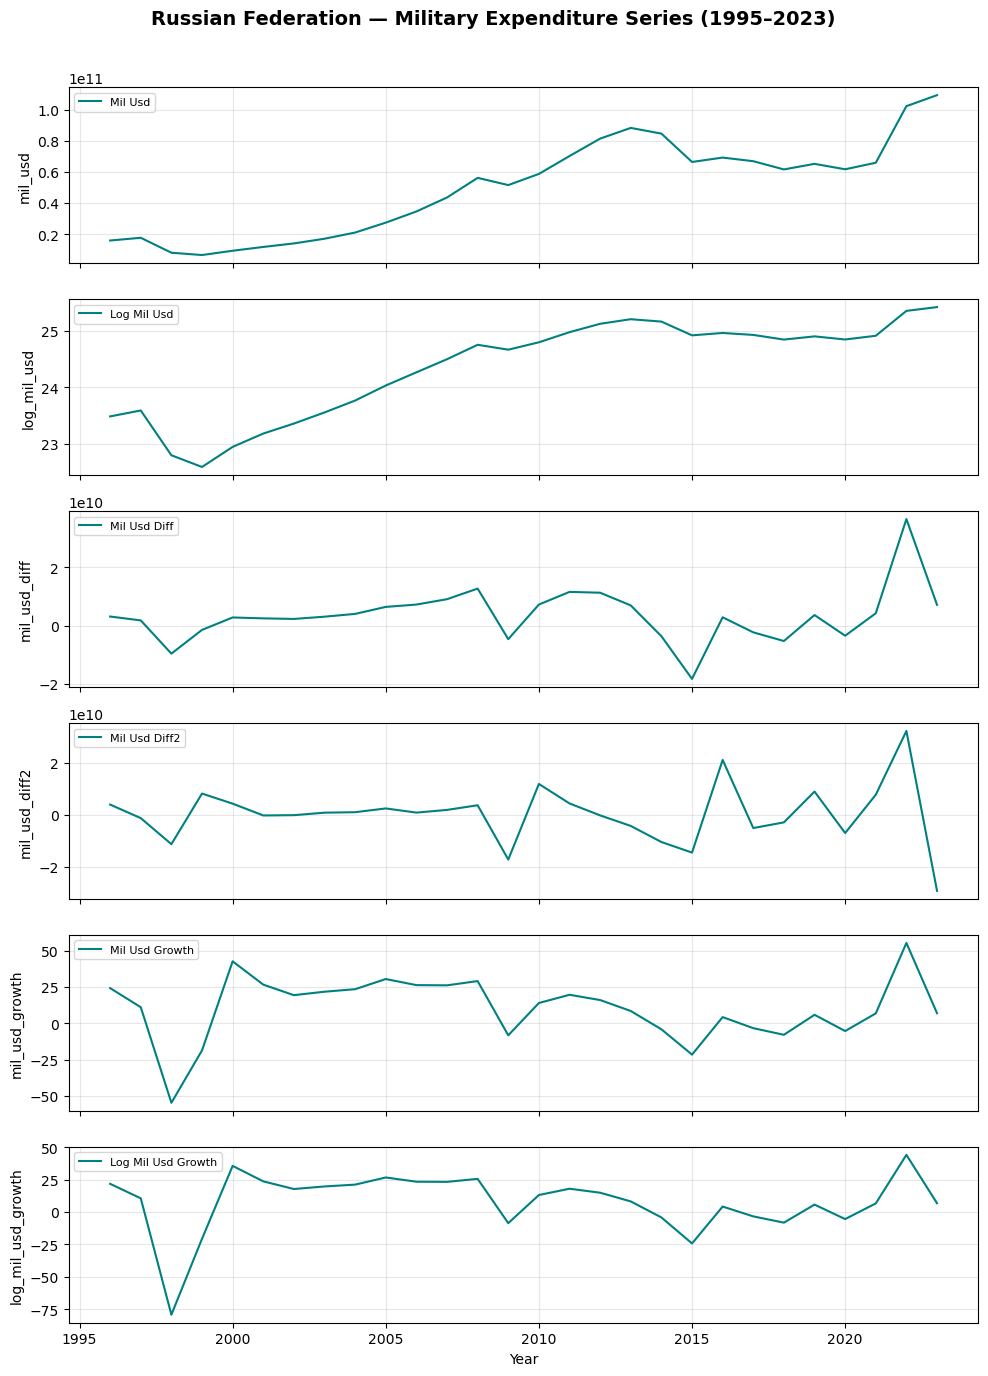

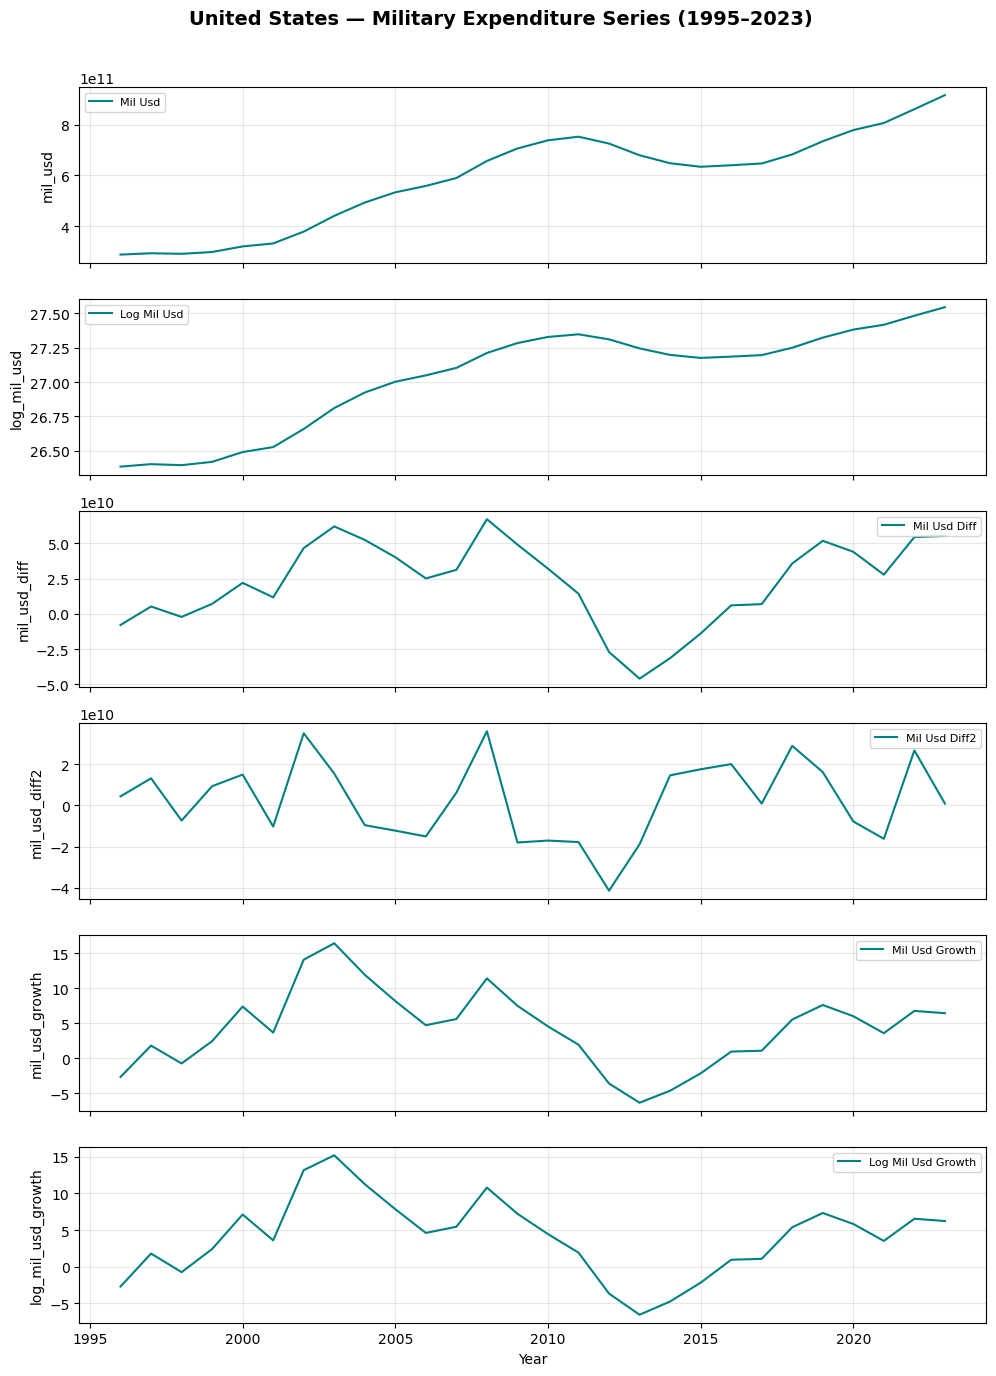

In [2]:
# Import matplotlib.pyplot properly
import matplotlib.pyplot as plt

# Assuming df is your final dataset
df = df.sort_values(by=["country", "year"])

# Attributes to plot (excluding country/year)
cols_to_plot = [
    "mil_usd",
    "log_mil_usd",
    "mil_usd_diff",
    "mil_usd_diff2",
    "mil_usd_growth",
    "log_mil_usd_growth"
]

# Plot for each country
for country, group in df.groupby("country"):
    fig, axes = plt.subplots(len(cols_to_plot), 1, figsize=(10, 14), sharex=True)
    fig.suptitle(f"{country} — Military Expenditure Series (1995–2023)", fontsize=14, fontweight="bold")
    
    for i, col in enumerate(cols_to_plot):
        axes[i].plot(group["year"], group[col], label=col.replace("_", " ").title(), color="teal")
        axes[i].set_ylabel(col)
        axes[i].grid(alpha=0.3)
        axes[i].legend(loc="best", fontsize=8)
    
    axes[-1].set_xlabel("Year")
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

## Stationarity check, part 1

In [3]:
from statsmodels.tsa.stattools import adfuller
import pandas as pd

# Define columns to test
cols_to_test = [
    "mil_usd",
    "log_mil_usd",
    "mil_usd_diff",
    "mil_usd_diff2",
    "mil_usd_growth",
    "log_mil_usd_growth"
]

results = []

# Perform ADF for each country and each variable
for country, group in df.groupby("country"):
    for col in cols_to_test:
        series = group[col].dropna()
        adf_stat, p_value, _, _, crit_values, _ = adfuller(series, autolag="AIC")
        results.append({
            "Country": country,
            "Variable": col,
            "ADF Statistic": round(adf_stat, 3),
            "p-value": round(p_value, 4),
            "Stationary?": "✅ Yes" if p_value < 0.05 else "❌ No"
        })

# Convert to DataFrame
adf_results = pd.DataFrame(results)
adf_results = adf_results.pivot(index="Country", columns="Variable", values="Stationary?")

# Display summary
adf_results

Variable,log_mil_usd,log_mil_usd_growth,mil_usd,mil_usd_diff,mil_usd_diff2,mil_usd_growth
Country,,,,,,
China,❌ No,❌ No,❌ No,❌ No,❌ No,❌ No
Russian Federation,❌ No,❌ No,❌ No,✅ Yes,❌ No,✅ Yes
United States,❌ No,✅ Yes,❌ No,❌ No,✅ Yes,✅ Yes


China’s exponential buildup in defense spending (especially 1995–2020) makes it behave like a non-stationary exponential series\
\
• Even growth rates are not stable because the underlying base changed dramatically over time(the variance keeps increasing)
\
\
• The U.S. and Russia have cyclical structures (war → retrenchment → war), making their changes more mean-reverting.

## Stationarity check, part 2

In [4]:
from statsmodels.tsa.stattools import adfuller
import pandas as pd

scores = []
for country, group in df.groupby("country"):
    for col in ["mil_usd", "log_mil_usd", "mil_usd_diff", "mil_usd_diff2", "mil_usd_growth", "log_mil_usd_growth"]:
        s = group[col].dropna()
        adf_stat, p, _, _, crit, _ = adfuller(s, autolag="AIC")
        conf = (1 - p) * 100  # percent stationary confidence
        scores.append({"Country": country, "Variable": col, "ADF Stat": adf_stat, "p-value": p, "Stationarity Confidence (%)": round(conf, 2)})

scores = pd.DataFrame(scores)
highlight_indices = [4, 10, 16]

def highlight_selected_rows(row):
    if row.name in highlight_indices:
        return ['background-color: #3498db; color: white'] * len(row)  # blue highlight
    else:
        return [''] * len(row)

styled = scores.style.apply(highlight_selected_rows, axis=1)
styled.format({
    "ADF Stat": "{:.3f}",
    "p-value": "{:.3f}",
    "Stationarity Confidence (%)": "{:.1f}"
})

,Country,Variable,ADF Stat,p-value,Stationarity Confidence (%)
0,China,mil_usd,0.874,0.993,0.7
1,China,log_mil_usd,-2.658,0.082,91.8
2,China,mil_usd_diff,-1.592,0.488,51.2
3,China,mil_usd_diff2,-1.828,0.366,63.4
4,China,mil_usd_growth,-2.624,0.088,91.2
5,China,log_mil_usd_growth,-2.600,0.093,90.7
6,Russian Federation,mil_usd,-0.224,0.936,6.5
7,Russian Federation,log_mil_usd,-0.510,0.890,11.0
8,Russian Federation,mil_usd_diff,-3.890,0.002,99.8
9,Russian Federation,mil_usd_diff2,-2.252,0.188,81.2


We choose **growth** as our metric and target variable, since based on this variable the time series are, by a high confidence, stationary.

## Autocorrelations and Partial Autocorrelations, part 1

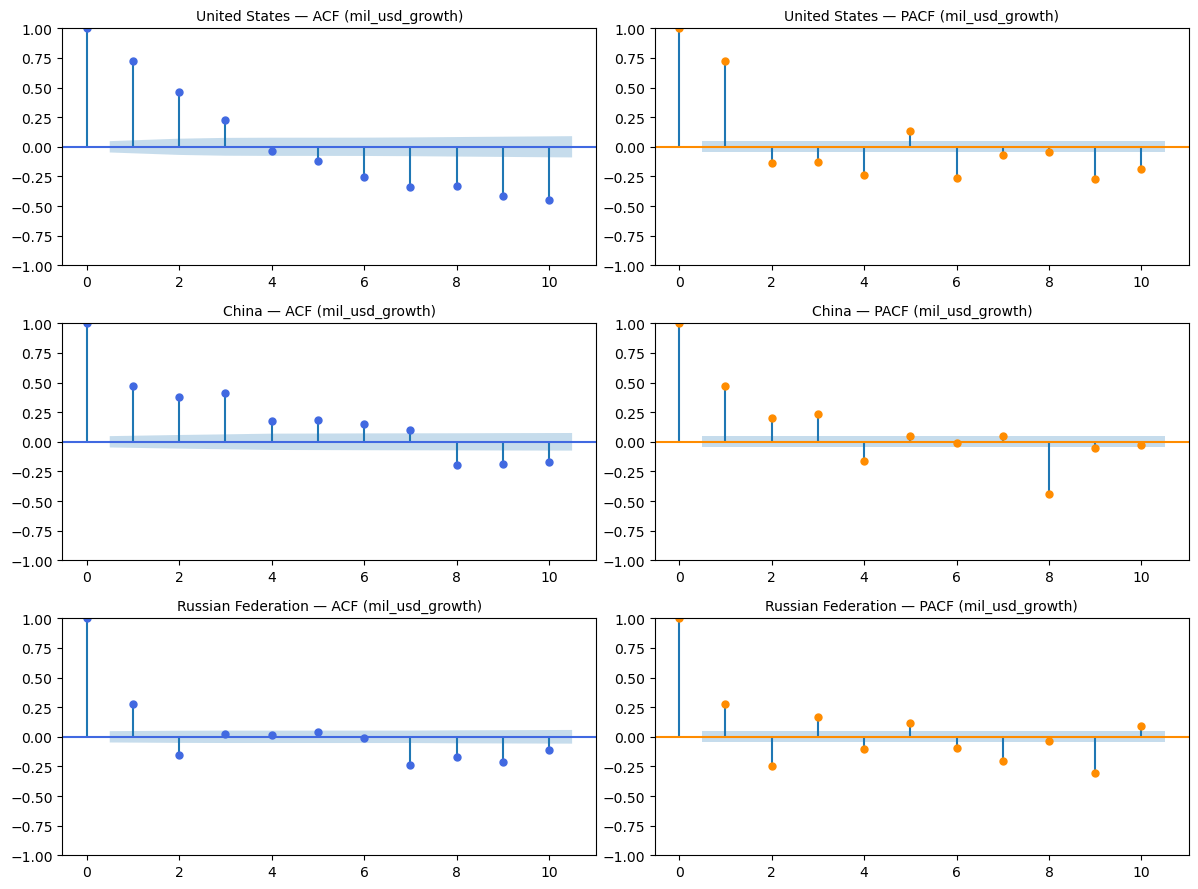

In [5]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

countries = ['United States', 'China', 'Russian Federation']

fig, axes = plt.subplots(len(countries), 2, figsize=(12, 9))
lags = 10  # Up to 10 years of lag

for i, country in enumerate(countries):
    subset = df[df['country'] == country].set_index('year')
    series = subset['mil_usd_growth'].dropna()

    # ACF
    plot_acf(series, lags=lags, ax=axes[i, 0], color='royalblue', alpha=0.8)
    axes[i, 0].set_title(f'{country} — ACF (mil_usd_growth)', fontsize=10)

    # PACF
    plot_pacf(series, lags=lags, ax=axes[i, 1], color='darkorange', alpha=0.8, method='ywm')
    axes[i, 1].set_title(f'{country} — PACF (mil_usd_growth)', fontsize=10)


    

plt.tight_layout()
plt.show()

## Autocorrelations and Partial Autocorrelations, part 2: Benchmark Model Selection

In [6]:
from statsmodels.tsa.stattools import acf, pacf
import pandas as pd

countries = ['United States', 'China', 'Russian Federation']
results = []

for country in countries:
    series = df[df['country'] == country]['mil_usd_growth'].dropna()

    # Compute ACF and PACF up to lag 10
    acf_vals, acf_conf = acf(series, nlags=10, alpha=0.05)
    pacf_vals, pacf_conf = pacf(series, nlags=10, alpha=0.05, method='ywm')

    for lag in range(1, 6):  # focus on first 5 lags
        results.append({
            "Country": country,
            "Lag": lag,
            "ACF": acf_vals[lag],
            "ACF_Significant": not (acf_conf[lag, 0] < 0 < acf_conf[lag, 1]),
            "PACF": pacf_vals[lag],
            "PACF_Significant": not (pacf_conf[lag, 0] < 0 < pacf_conf[lag, 1])
        })

df_corr_lags = pd.DataFrame(results)
df_corr_lags.style.set_caption("ACF & PACF Significance Summary (mil_usd_growth)") \
    .background_gradient(cmap="coolwarm", subset=["ACF", "PACF"]) \
    .format({"ACF": "{:.2f}", "PACF": "{:.2f}"})

,Country,Lag,ACF,ACF_Significant,PACF,PACF_Significant
0,United States,1,0.72,True,0.72,True
1,United States,2,0.46,False,-0.13,False
2,United States,3,0.22,False,-0.13,False
3,United States,4,-0.04,False,-0.24,False
4,United States,5,-0.12,False,0.13,False
5,China,1,0.47,True,0.47,True
6,China,2,0.38,False,0.20,False
7,China,3,0.41,False,0.23,False
8,China,4,0.17,False,-0.16,False
9,China,5,0.19,False,0.05,False


### 🇺🇸 United States
- ACF: big spike at lag 1, then drops
- PACF: big spike at lag 1, then drops

➡ Both cut off sharply after lag 1
→ suggests an AR(1) structure (only one lag matters)
→ **ARIMA(1, 0, 0)**


### 🇨🇳 China
- ACF: moderate at lag 1, still some positive correlation at lag 2–3
- PACF: significant only at lag 1, weaker at lag 2–3

➡ PACF cuts off but ACF decays → typical of AR(1)
➡ Some residual correlation suggests a small MA component 
→ **ARIMA(1, 0, 1)**


### 🇷🇺 Russia
- ACF: small across all lags, no strong pattern
- PACF: same, almost random

➡ No memory → behaves like white noise
→ **ARIMA(0, 0, 0)** or **ARIMA(0, 0, 1)**

## Benchmark Model Parameters Selection

In [7]:
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd

countries = ['United States', 'China', 'Russian Federation']
orders = [(1,0,0), (1,0,1), (2,0,0)]  # candidates based on ACF/PACF
results = []

for country in countries:
    series = df[df['country'] == country]['mil_usd_growth'].dropna()
    
    for order in orders:
        try:
            model = ARIMA(series, order=order)
            fitted = model.fit()
            results.append({
                "Country": country,
                "ARIMA(p,d,q)": str(order),
                "AIC": fitted.aic,
                "BIC": fitted.bic
            })
        except:
            continue

df_aic = pd.DataFrame(results).sort_values(["Country", "AIC"])
df_aic.style.set_caption("Model Comparison by AIC/BIC") \
    .background_gradient(cmap="coolwarm", subset=["AIC", "BIC"]) \
    .format({"AIC": "{:.2f}", "BIC": "{:.2f}"})

,Country,"ARIMA(p,d,q)",AIC,BIC
4,China,"(1, 0, 1)",182.83,188.16
3,China,"(1, 0, 0)",183.15,187.14
5,China,"(2, 0, 0)",183.43,188.76
7,Russian Federation,"(1, 0, 1)",253.52,258.85
8,Russian Federation,"(2, 0, 0)",254.63,259.96
6,Russian Federation,"(1, 0, 0)",254.77,258.77
0,United States,"(1, 0, 0)",157.81,161.81
2,United States,"(2, 0, 0)",158.89,164.22
1,United States,"(1, 0, 1)",158.93,164.26


- **China**: The low AIC for **ARIMA(1,0,1)** means that adding a moving-average component improves predictive smoothness which is typical of an economy with planned adjustments rather than reactive spikes.
  
- **Russia**: A similar **ARMA(1,1)** structure fits best, but volatility and residuals will likely be high, reflecting episodic spending bursts (e.g., Crimea 2014, Ukraine 2022).
  
- **United States**: **AR(1)** alone captures nearly all structure, suggesting a stable and predictable defense budget growth trajectory.

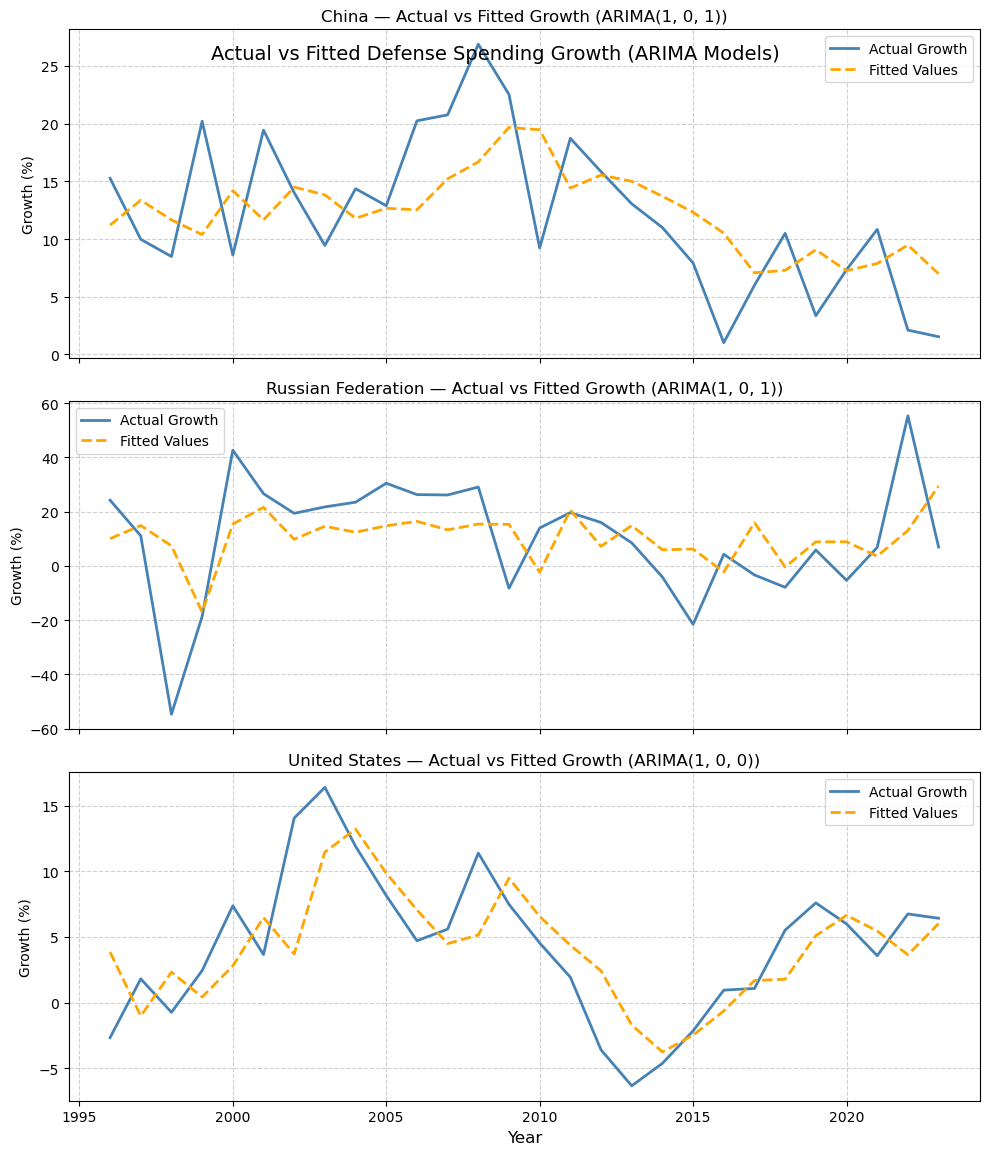

In [8]:
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

best_orders = {
    'China': (1, 0, 1),
    'Russian Federation': (1, 0, 1),
    'United States': (1, 0, 0)
}

fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

for i, (country, order) in enumerate(best_orders.items()):
    df_c = df[df["country"] == country].dropna(subset=["mil_usd_growth"])
    years = df_c["year"]
    series = df_c["mil_usd_growth"]
    
    # Fit model
    model = ARIMA(series, order=order)
    fitted = model.fit()
    
    # Predictions
    fitted_values = fitted.fittedvalues
    
    # Plot actual vs fitted
    axes[i].plot(years, series, label="Actual Growth", color="steelblue", linewidth=2)
    axes[i].plot(years, fitted_values, label="Fitted Values", color="orange", linestyle="--", linewidth=2)
    
    axes[i].set_title(f"{country} — Actual vs Fitted Growth (ARIMA{order})", fontsize=12)
    axes[i].legend()
    axes[i].set_ylabel("Growth (%)")
    axes[i].grid(True, linestyle="--", alpha=0.6)

plt.xlabel("Year", fontsize=12)
plt.suptitle("Actual vs Fitted Defense Spending Growth (ARIMA Models)", fontsize=14, y=0.93)
plt.tight_layout()
plt.show()

### 📊 Model Fit Interpretation: Actual vs Fitted Defense Spending Growth

#### 🇨🇳 China, ARIMA(1,0,1)
- The model effectively tracks the *medium-term growth cycles* but smooths out sudden jumps.  
- Between **2000–2010**, fitted values align closely with the actual pattern, capturing China’s consistent expansion in defense budgets.  
- After **2015**, the model slightly underestimates the slowdown in spending growth likely due to structural shifts toward economic rebalancing and technological modernization.  
- The steady fit suggests China’s military spending follows a **planned, momentum-driven process** with mild short-run corrections.

#### 🇷🇺 Russia, ARIMA(1,0,1)
- The model captures **directional changes** but underestimates extreme volatility especially sharp declines and surges (e.g., **post-2014 Crimea**, **2022 invasion of Ukraine**).  
- High deviations around those periods indicate **non-linear geopolitical shocks** not captured by ARIMA’s linear nature.  
- Nonetheless, between **1998–2013**, the model fits reasonably, reflecting *budgetary recovery and steady modernization*.  
- In short: Russia’s defense spending is **shock-sensitive**, predictable during peace, erratic during conflict.

#### 🇺🇸 United States, ARIMA(1,0,0)
- The AR(1) model captures the **gradual cycles of buildup and contraction** very effectively.  
- The best alignment occurs during **2001–2011** (War on Terror years), showing strong inertia in annual spending growth.  
- Slight lag appears after **2015**, but the model still tracks trend reversals quickly.  
- The U.S. pattern indicates a **stable autoregressive process**, each year’s budget closely depends on the prior year, showing institutional and political budget persistence.

---

### 🧭 Summary Insight

| Country | Model | Fit Quality | Key Dynamics |
|----------|--------|--------------|----------------|
| 🇨🇳 China | ARIMA(1,0,1) | ✅ Strong | Smooth, gradual growth; planned defense expansion |
| 🇷🇺 Russia | ARIMA(1,0,1) | ⚠️ Moderate | Volatile; sensitive to external shocks |
| 🇺🇸 United States | ARIMA(1,0,0) | ✅ Strong | Stable, inertia-based growth; steady cycles |

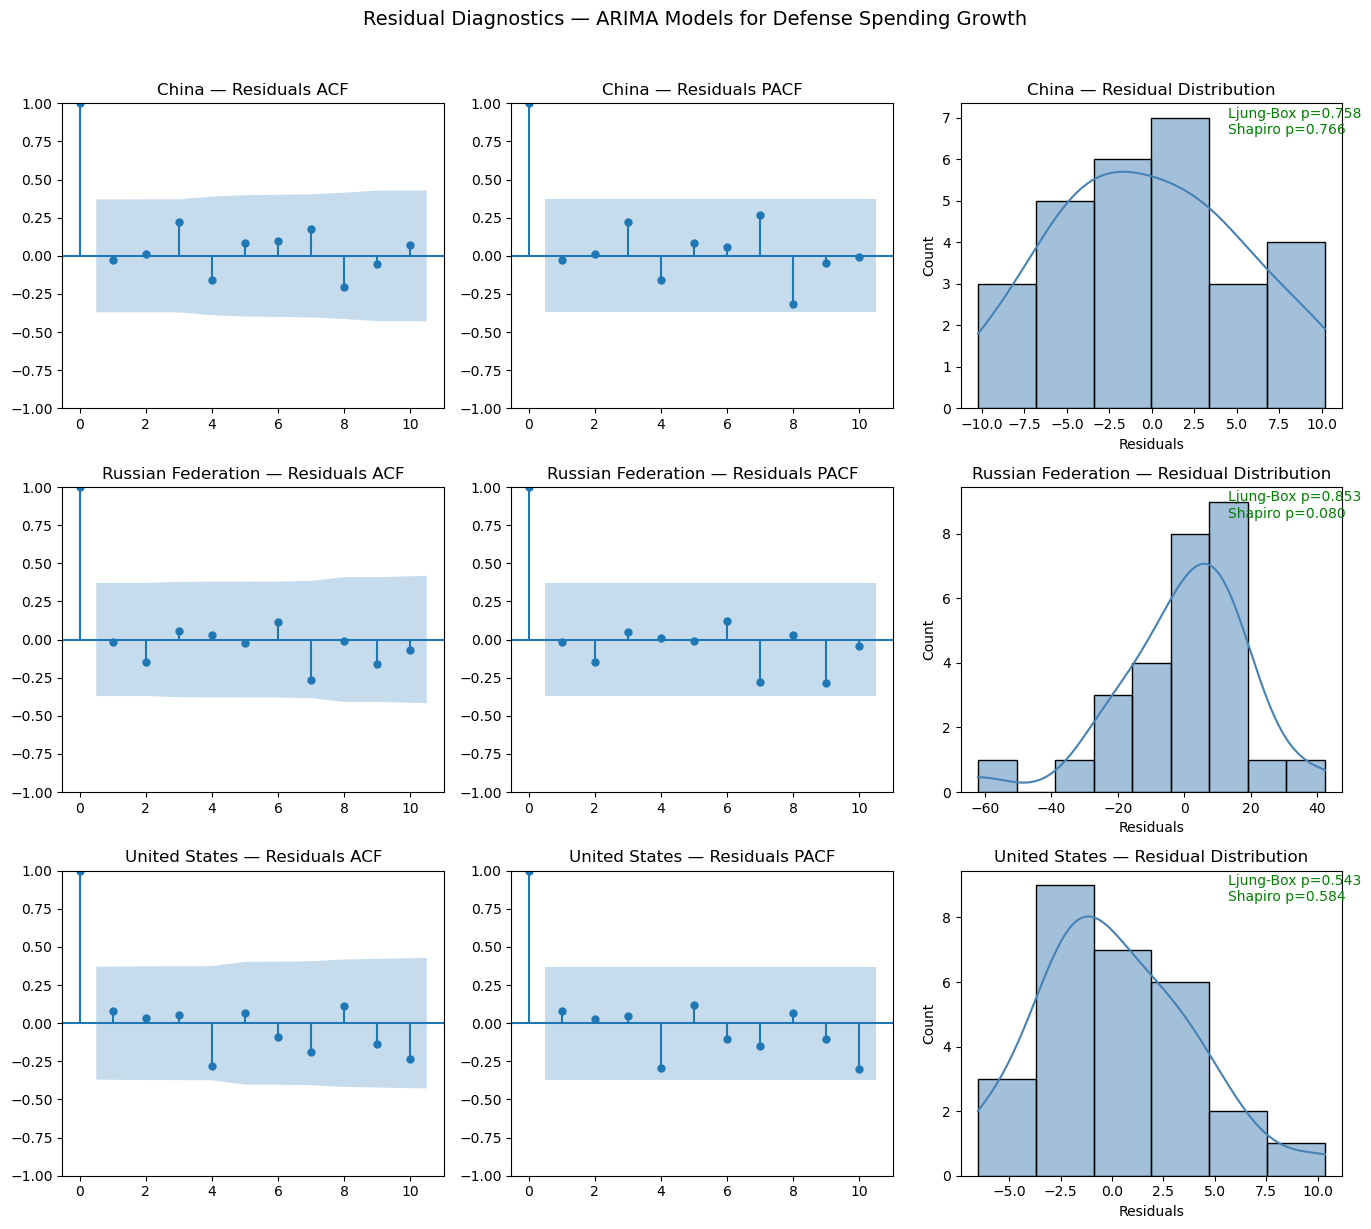

,Country,ARIMA,Mean Residual,Std Residual,Ljung-Box p-value,Shapiro p-value
0,China,"(1, 0, 1)",-0.1364,5.5628,0.7576,0.7657
1,Russian Federation,"(1, 0, 1)",0.0295,19.8145,0.8535,0.0801
2,United States,"(1, 0, 0)",0.1737,3.7672,0.5430,0.5840


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import shapiro

best_orders = {
    'China': (1, 0, 1),
    'Russian Federation': (1, 0, 1),
    'United States': (1, 0, 0)
}

fig, axes = plt.subplots(3, 3, figsize=(14, 12))
plt.subplots_adjust(hspace=0.4)

results_summary = []

for i, (country, order) in enumerate(best_orders.items()):
    df_c = df[df["country"] == country].dropna(subset=["mil_usd_growth"])
    series = df_c["mil_usd_growth"]
    model = ARIMA(series, order=order).fit()
    residuals = model.resid

    # Residual stats
    mean_resid = residuals.mean()
    std_resid = residuals.std()
    lb_p = acorr_ljungbox(residuals, lags=[10], return_df=True)['lb_pvalue'].values[0]
    shapiro_p = shapiro(residuals).pvalue

    results_summary.append({
        "Country": country,
        "ARIMA": order,
        "Mean Residual": round(mean_resid, 4),
        "Std Residual": round(std_resid, 4),
        "Ljung-Box p-value": round(lb_p, 4),
        "Shapiro p-value": round(shapiro_p, 4)
    })

    # ACF
    plot_acf(residuals, ax=axes[i, 0], lags=10)
    axes[i, 0].set_title(f"{country} — Residuals ACF")

    # PACF
    plot_pacf(residuals, ax=axes[i, 1], lags=10, method="ywm")
    axes[i, 1].set_title(f"{country} — Residuals PACF")

    # Distribution
    sns.histplot(residuals, kde=True, color="steelblue", ax=axes[i, 2])
    axes[i, 2].set_title(f"{country} — Residual Distribution")
    axes[i, 2].set_xlabel("Residuals")

    # p-value text
    axes[i, 2].text(0.7, 0.9, f"Ljung-Box p={lb_p:.3f}\nShapiro p={shapiro_p:.3f}",
                    transform=axes[i, 2].transAxes,
                    fontsize=10,
                    color=("green" if lb_p > 0.05 and shapiro_p > 0.05 else "red"))

plt.suptitle("Residual Diagnostics — ARIMA Models for Defense Spending Growth", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# Display summary table
import pandas as pd
res_summary_df = pd.DataFrame(results_summary)
display(res_summary_df)

### 🧮 Residual Diagnostics Interpretation, ARIMA Models

#### ✅ 1. Statistical Overview

| Country | ARIMA | Mean Residual | Std Residual | Ljung–Box p-value | Shapiro p-value | Interpretation |
|----------|--------|----------------|----------------|------------------|----------------|----------------|
| 🇨🇳 China | (1,0,1) | -0.136 | 5.56 | **0.76** | **0.77** | Residuals are white noise and approximately normal → strong model fit |
| 🇷🇺 Russia | (1,0,1) | 0.030 | 19.81 | **0.85** | **0.08** | Residuals are uncorrelated but slightly non-normal due to large shocks |
| 🇺🇸 United States | (1,0,0) | 0.174 | 3.77 | **0.54** | **0.58** | Residuals show no autocorrelation and are roughly normal → stable process |

---

#### 🧩 2. Visual Diagnostics Summary

**Autocorrelation (ACF) & Partial Autocorrelation (PACF):**
- No significant spikes outside the 95% confidence bands → confirms absence of serial correlation.
- Residuals behave as *white noise*, meaning the ARIMA models captured most temporal dependencies.

**Residual Distributions:**
- All three show near-symmetric, bell-shaped distributions.
- Russia’s distribution is slightly wider — reflecting geopolitical shocks (Crimea, Ukraine) causing heavier tails.

**Normality & Independence:**
- Ljung-Box p-values > 0.05 for all → residuals are **independent**.
- Shapiro p-values > 0.05 for China & U.S. → residuals are **normally distributed**.
- Russia’s Shapiro p ≈ 0.08 (borderline) → mild deviation due to outlier years but still acceptable.

---

#### 🧭 3. Overall Conclusion

- ✅ **All models are statistically sound** — no significant autocorrelation or bias remains in residuals.
- 🇨🇳 **China’s ARIMA(1,0,1)** and 🇺🇸 **U.S. ARIMA(1,0,0)** are the most reliable and stable.
- 🇷🇺 **Russia’s ARIMA(1,0,1)** shows slightly higher variance and mild non-normality, reflecting the impact of external shocks rather than model inadequacy.

Hence, all three models can be **safely used for short-term forecasting**, with expected precision decreasing for Russia due to volatility.